In [1]:
%cd ..

/pub/hofmann-scratch/glanzillo/ded


In [2]:

import importlib
import json
import math
import os
import socket
import sys
import time


internal_path = os.path.abspath(os.path.join('.'))
sys.path.append(internal_path)
sys.path.append(internal_path + '/datasets')
sys.path.append(internal_path + '/utils')

import datetime
import uuid
from argparse import ArgumentParser

import setproctitle
import torch
import numpy as np
import pandas as pd 
import json

from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.collections import LineCollection



import shutil
from utils.args import add_management_args, add_rehearsal_args
from utils.conf import set_random_seed, get_device, base_path
from utils.status import ProgressBar
from utils.stil_losses import *
from utils.nets import *
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import ConcatDataset
from torchvision.models import efficientnet_v2_s, resnet50, ResNet50_Weights, googlenet, efficientnet_b0, mobilenet_v3_large
from utils.eval import evaluate, validation_and_agreement, distance_models, validation_agreement_function_distance
from dataset_utils.data_utils import load_dataset, CIFAR100sparse2coarse



/local/home/glanzillo/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Feature kernel calculation

In [37]:
def HSIC(K,L):
    """Computes Hilbert-Schmidt Independence Criterion of matrices K and L"""
    n = K.shape[0]
    H = np.eye(n) - np.ones((n,n))/n 
    KH = np.matmul(K,H)
    LH = np.matmul(L,H)
    HSIC = np.trace(np.matmul(KH,LH))/((n-1)**2)
    return HSIC

def centered_kernal_alignment(K,L):
    """ computes CKA index based on two empirical Kernel matrices.
    See https://arxiv.org/pdf/1905.00414.pdf for more info."""
    CKA = HSIC(K,L) / np.sqrt(HSIC(K,K)*HSIC(L,L))
    return CKA


In [38]:
def compute_empirical_kernel(data_loader, model, device, num_batches=100):
    # running estimate of the outer products and mean
    total=0
    progress_bar = ProgressBar(verbose=True)

    model = feature_wrapper(model) # adding 'get_features' function
    features = [] # we collect all the features in a matrix
    for i, data in enumerate(data_loader):
        if i==num_batches: break 
        with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                B = inputs.size(0)
                phi = model.get_features(inputs)
                # normalising the features to have norm one 
                phi = phi.view(B,-1)
                phi = torch.div(phi, phi.norm(dim=1).view(B,1))

                features.append(phi)

                total += B
                
        progress_bar.prog(i, len(data_loader), -1, 'Collecting features', i/(min(len(data_loader),num_batches)))  
    
    F = phi.size(1) # feature dimensionality
    features = torch.vstack(features).view(total, F).cpu().numpy()

    kernel_matrix = np.matmul(features, features.T)
    return kernel_matrix

In [5]:
def plot_matrix(M, title, size=(8,10)):
    fig, ax = plt.subplots(figsize=size)
    mat = ax.matshow(M)
    ax.set_title(title,fontsize=20)
    ax.tick_params(axis='x', colors='black', top=False, labelbottom=True, labeltop=False)
    ax.tick_params(axis='y', colors='black', bottom=True, top=False)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    fig.colorbar(mat, cax=cbar_ax, fraction=0.046, pad=0.04)

    plt.show()
    return fig

In [6]:
GPUID = 5
#os.environ["CUDA_VISIBLE_DEVICES"]=str(GPUID)
device = get_device([GPUID])

In [8]:
#device='cpu'

### IMAGENET

In [ ]:
NUM_SAMPLES = 500000

In [ ]:
imagenet_root = "/local/home/stuff/imagenet/"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

inference_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,
                ])

train_dataset = ImageFolder(imagenet_root+'train', inference_transform)
all_indices = set(range(len(train_dataset)))
random_indices = np.random.choice(list(all_indices), size=NUM_SAMPLES, replace=False)
data = Subset(train_dataset, random_indices)
loader = DataLoader(data, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)

# val_dataset = ImageFolder(imagenet_root+'val', inference_transform)
# all_data = ConcatDataset([train_dataset, val_dataset])
# all_data_loader = DataLoader(all_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=False)

In [ ]:

def load_checkpoint(best=False, filename='checkpoint.pth.tar', student=False):
    path = base_path() + "chkpts" + "/" + "imagenet" + "/" + "resnet50/"
    if best: filepath = path + 'model_best.pth.tar'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)  
          if not student: 
              new_state_dict = {k.replace('module.','',1):v for (k,v) in checkpoint['state_dict'].items()}
              checkpoint['state_dict'] = new_state_dict
          return checkpoint
    return None 

In [ ]:
# initialising the model
teacher = model = resnet50(weights=None)

CHKPT_NAME = 'rn50_2023-02-21_10-45-30_best.ckpt'
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME, student=False) 
if checkpoint: 
        teacher.load_state_dict(checkpoint['state_dict'])
        teacher.to(device)

Loading existing checkpoint ./logs/chkpts/imagenet/resnet50/rn50_2023-02-21_10-45-30_best.ckpt


### CIFAR 5M

In [6]:
NUM_SAMPLES = 500000

In [7]:

C5m_train, C5m_test = load_dataset('cifar5m', augment=False)

print(f"Randomly drawing {NUM_SAMPLES} samples for the Cifar5M base")
all_indices = set(range(len(C5m_train)))
random_indices = np.random.choice(list(all_indices), size=NUM_SAMPLES, replace=False)
data = Subset(C5m_train, random_indices)
loader = DataLoader(data, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)

Loading CIFAR 5mil...
Loaded part 1/6
Loaded part 2/6
Loaded part 3/6
Loaded part 4/6
Loaded part 5/6
Loaded part 6/6
Randomly drawing 500000 samples for the Cifar5M base


In [10]:
def load_checkpoint(best=False, filename='checkpoint.pth.tar', type='mnet'):
    """ Available network types: [mnet, convnet]"""
    path = base_path() + "chkpts" + "/" + "cifar5m" + "/" + f"{type}/"
    if best: filepath = path + 'model_best.ckpt'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)
          return checkpoint
    return None 


In [16]:
# ENTROPY = 0.35
teacher = mobilenet_v3_large(num_classes=10) # adjusting for CIFAR 
CHKPT_NAME = f'mnet-teacher.ckpt' 

In [ ]:
# ENTROPY = 2.26
teacher = make_cnn(c=20, num_classes=10, use_batch_norm=True)
CHKPT_NAME = f'convnet-teacher.ckpt' 

CNN made with 154250 parameters


In [26]:
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME, type='mnet') 
if checkpoint: 
        teacher.load_state_dict(checkpoint['state_dict'])
        teacher.to(device)

Loading existing checkpoint ./logs/chkpts/cifar5m/mnet/mnet-teacher.ckpt


RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [20]:

SEEDS = [11, 13, 21, 33, 55]
BUFFER_SIZES = [1200, 6000, 12000, 24000, 60000, 120000, 600000]

In [24]:
SigmaT = compute_covariance(loader, teacher, num_classes=10, device=device)

/tmp/ipykernel_1358777/4231022350.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs.view(-1,num_classes,1))
[ 11-28 | 11:35 ] Task Computing covariance | epoch -1: |██┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 6.84 ep/h | loss: 0.05093422 |

KeyboardInterrupt: 

In [30]:
student = mobilenet_v3_large(num_classes=10) # adjusting for CIFAR 
#student = make_cnn(c=20, num_classes=10, use_batch_norm=True)
seed = SEEDS[0]
buffer_size = BUFFER_SIZES[3]
alpha = 1.0
STUDNT_NAME = f'mnet-student-{seed}-{buffer_size}-{alpha}.ckpt'
#STUDNT_NAME = 'rn50-student-11-90000-1.0.ckpt'
checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME, student=True) 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/imagenet/resnet50/rn50-student-11-90000-1.0.ckpt


In [31]:
SigmaS_2 = compute_covariance(loader, student, num_classes=1000)

/tmp/ipykernel_424074/2006101374.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs.view(-1,num_classes,1))
[ 11-21 | 15:33 ] Task Computing covariance | epoch -1: |██████████████████████████████████████████████████| 6.64 ep/h | loss: 0.99974405 |

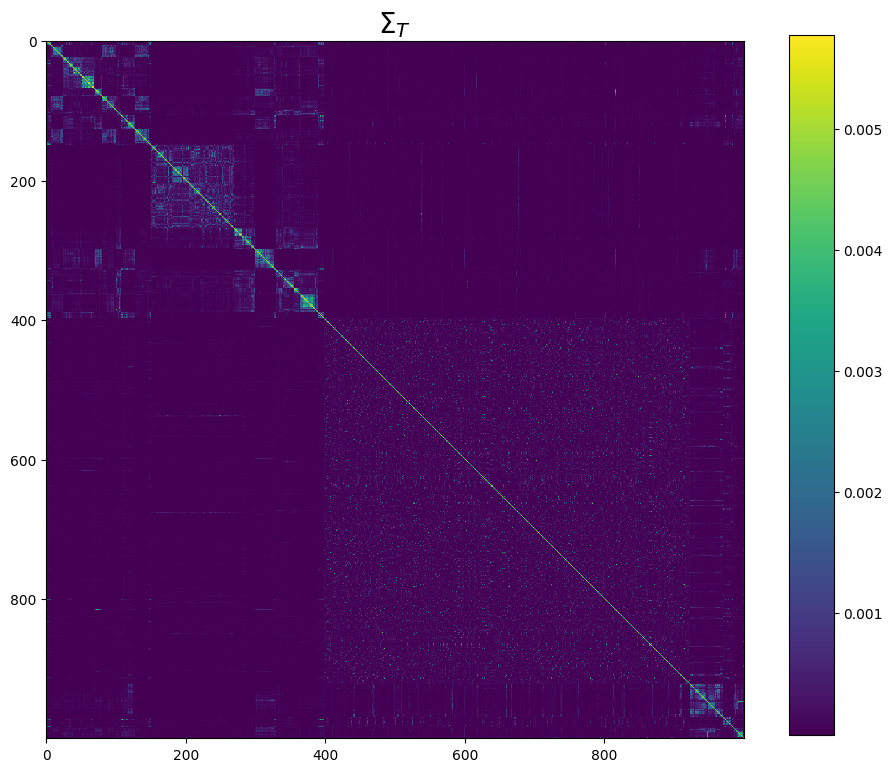

In [18]:
plot_covariance(SigmaT, r'$\Sigma_T$', size=(9,10));

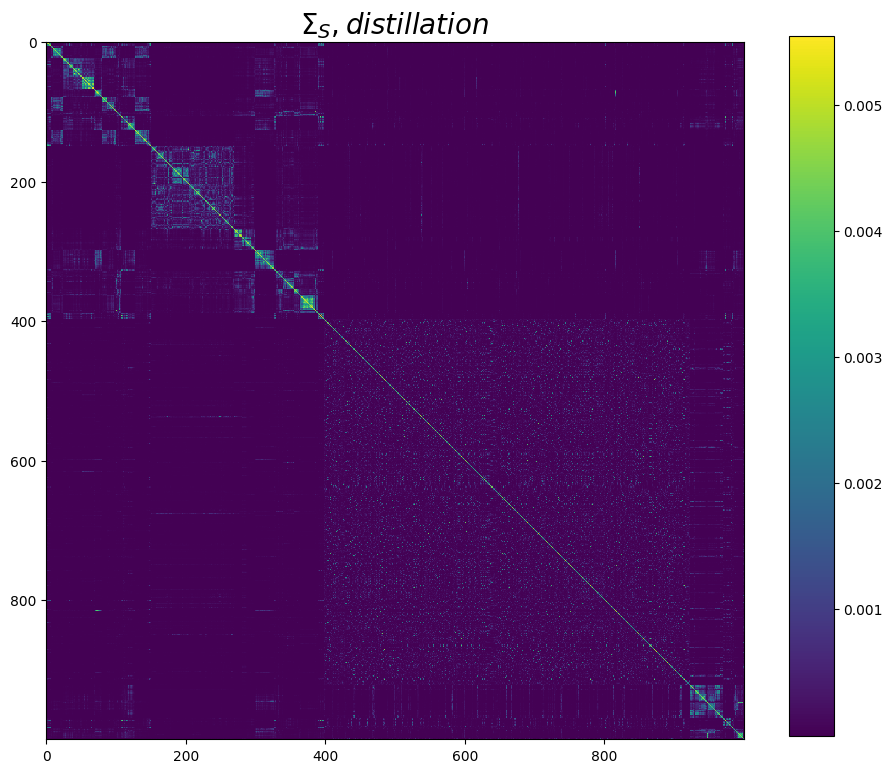

In [29]:
plot_covariance(SigmaS, r'$\Sigma_S, distillation$', size=(9,10));

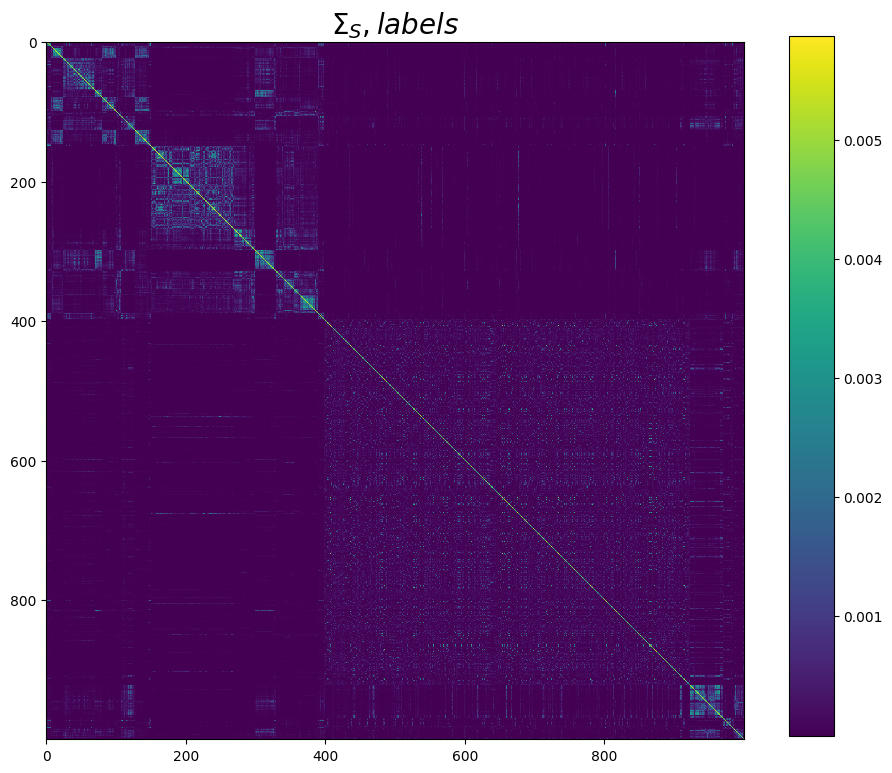

In [32]:
plot_covariance(SigmaS_2, r'$\Sigma_S, labels$', size=(9,10));

### CIFAR 100

In [33]:
NUM_BATCHES=10

In [77]:

C100_train, C100_val = load_dataset('cifar100', augment=False)
all_data = ConcatDataset([C100_train, C100_val])
shuffled_train = torch.utils.data.Subset(C100_train, torch.randperm(len(C100_train)).tolist())
loader = DataLoader(shuffled_train, batch_size=128, shuffle=False, num_workers=4, pin_memory=False)

In [10]:
len(loader)

391

In [21]:
def load_checkpoint(best=False, filename='checkpoint.pth.tar', distributed=False):
    path = base_path() + "chkpts" + "/" + "cifar100" + "/" + "resnet18/"
    if best: filepath = path + 'model_best.ckpt'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)
          return checkpoint
    return None 

Loading the teacher and computing the kernel

In [68]:
# initialising the model
teacher = resnet18(num_classes=100)
#teacher = make_cnn(c=150, num_classes=100, use_batch_norm=True)
CHKPT_NAME = 'resnet18-teacher.ckpt'
#CHKPT_NAME = 'convnet150-teacher.ckpt'
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME) 
if checkpoint: 
        teacher.load_state_dict(checkpoint['state_dict'])
        teacher.to(device)

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-teacher.ckpt


In [78]:
KT = compute_empirical_kernel(loader, teacher, device=device, num_batches=NUM_BATCHES)

[ 12-01 | 14:18 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 372.52 ep/h | loss: 0.9 |

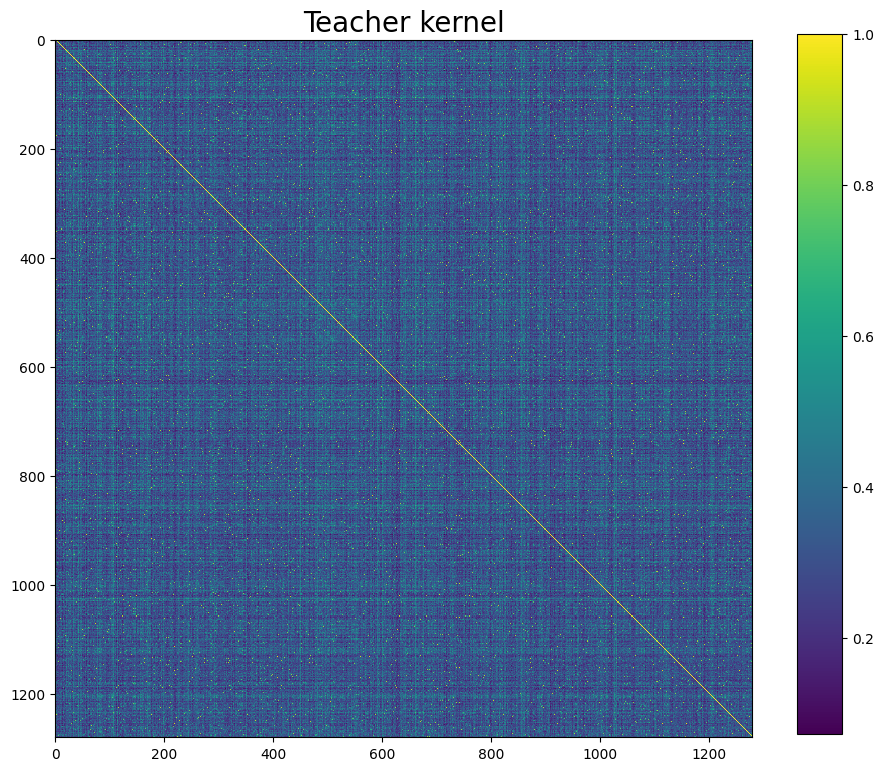

In [14]:
plot_matrix(KT, r'Teacher kernel', size=(9,10));

Loading the students and computing kernels

In [70]:
SEEDS = [11, 13, 21, 33, 55]

In [82]:
student = resnet18(num_classes=100)
alpha = 1.0
buffer_size = 24000
seed = 13
STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


In [83]:
KS0 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)

[ 12-01 | 14:19 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 402.85 ep/h | loss: 0.9 |

In [84]:
centered_kernal_alignment(KS0,KT)

0.6810538768983967

In [24]:
buffer_size = 24000
alpha = 1.0
alignments_1 = []
for seed in SEEDS:
    student = resnet18(num_classes=100)
    STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
    checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
    if checkpoint: 
            student.load_state_dict(checkpoint['state_dict'])
            student.to(device)
    KS1 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)
    alignments_1.append(centered_kernal_alignment(KS1,KT))
alignments_1

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:44 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 368.98 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:44 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 391.66 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:44 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.8 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:44 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 400.75 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:44 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 371.75 ep/h | loss: 0.9 |

[0.6768327489108363,
 0.6756104273978195,
 0.6808177522061001,
 0.6772146930234169,
 0.6816759064969254]

In [25]:
buffer_size = 24000
alpha = 0.0
alignments_0 = []
for seed in SEEDS:
    student = resnet18(num_classes=100)
    STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
    checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
    if checkpoint: 
            student.load_state_dict(checkpoint['state_dict'])
            student.to(device)
    KS1 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)
    alignments_0.append(centered_kernal_alignment(KS1,KT))
alignments_0

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:45 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 383.24 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:45 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.63 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:45 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.99 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:45 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 390.82 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:45 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 389.95 ep/h | loss: 0.9 |

[0.8321372182313193,
 0.8458086408606634,
 0.8461684980740904,
 0.8474502475276462,
 0.8478838172534987]

In [27]:
buffer_size = 24000
alpha = 0.0
A00 = np.zeros((len(SEEDS),len(SEEDS)))
for i,seed in enumerate(SEEDS):
    for j,seed2 in enumerate(SEEDS):
        student = resnet18(num_classes=100)
        STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
        checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
        if checkpoint: 
                student.load_state_dict(checkpoint['state_dict'])
                student.to(device)
        K1 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)

        student = resnet18(num_classes=100)
        STUDNT_NAME = f'resnet18-student-{seed2}-{buffer_size}-{alpha}.ckpt'
        checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
        if checkpoint: 
                student.load_state_dict(checkpoint['state_dict'])
                student.to(device)
        K2 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)
        A00[i,j] = centered_kernal_alignment(K1,K2)
A00

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 372.03 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 392.72 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.66 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.11 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 391.86 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.24 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 398.47 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.16 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 398.33 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 420.25 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 400.77 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.62 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 392.3 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.41 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.75 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.86 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.92 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 389.61 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 392.02 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.19 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.81 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.79 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 400.41 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.57 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.73 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.97 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.52 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.08 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.46 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.08 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 398.28 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.73 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.35 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 401.32 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.66 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.92 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 403.52 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 399.59 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.99 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.31 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.41 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.64 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 391.25 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 398.52 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.19 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.99 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.83 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.62 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.83 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.06 ep/h | loss: 0.9 |

array([[1.        , 0.88291069, 0.88322573, 0.88418155, 0.88176088],
       [0.88291069, 1.        , 0.88810322, 0.88977001, 0.89226183],
       [0.88322573, 0.88810322, 1.        , 0.88975531, 0.88728097],
       [0.88418155, 0.88977001, 0.88975531, 1.        , 0.8903652 ],
       [0.88176088, 0.89226183, 0.88728097, 0.8903652 , 1.        ]])

In [28]:
buffer_size = 24000
alpha = 1.0
A11 = np.zeros((len(SEEDS),len(SEEDS)))
for i,seed in enumerate(SEEDS):
    for j,seed2 in enumerate(SEEDS):
        student = resnet18(num_classes=100)
        STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
        checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
        if checkpoint: 
                student.load_state_dict(checkpoint['state_dict'])
                student.to(device)
        K1 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)

        student = resnet18(num_classes=100)
        STUDNT_NAME = f'resnet18-student-{seed2}-{buffer_size}-{alpha}.ckpt'
        checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
        if checkpoint: 
                student.load_state_dict(checkpoint['state_dict'])
                student.to(device)
        K2 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)
        A11[i,j] = centered_kernal_alignment(K1,K2)
A11

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 373.96 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.09 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 370.31 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 392.93 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.64 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.89 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.7 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 399.08 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 399.17 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.32 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.42 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.86 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 391.37 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 398.07 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.01 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.37 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.66 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 400.04 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.77 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.57 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.8 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 391.75 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.7 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.77 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.53 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.1 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.57 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.46 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.41 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.17 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 400.29 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 392.59 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 402.61 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 386.44 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 403.54 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.98 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.39 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 391.26 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.0 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.4 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.25 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.83 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.03 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.21 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.92 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 385.37 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.44 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.09 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 398.34 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.11 ep/h | loss: 0.9 |

array([[1.        , 0.65870329, 0.66293033, 0.66391039, 0.66131279],
       [0.65870329, 1.        , 0.66256096, 0.65783209, 0.66194115],
       [0.66293033, 0.66256096, 1.        , 0.66462679, 0.66232517],
       [0.66391039, 0.65783209, 0.66462679, 1.        , 0.66046506],
       [0.66131279, 0.66194115, 0.66232517, 0.66046506, 1.        ]])

## Reading and plotting results

In [3]:
logs_path = './logs/results/cifar100/resnet18/logs.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))
res_df = pd.DataFrame(results)
res_df

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam  \
0            no  0.1         True       False    0.0001       False   
1            no  0.1         True       False    0.0001       False   
2            no  0.1         True       False    0.0001       False   
3            no  0.1         True       False    0.0001       False   
4            no  0.1         True       False    0.0001       False   
..          ...  ...          ...         ...       ...         ...   
258          no  0.1         True       False    0.0001       False   
259          no  0.1         True       False    0.0001       False   
260          no  0.1         True       False    0.0001       False   
261          no  0.1         True       False    0.0001       False   
262          no  0.1         True       False    0.0001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...  \
0            0             5           False                True  ...   
1            0             5           False                True  ...   
2            0             5           False                True  ...   
3            0             5           False                True  ...   
4            0             5           False                True  ...   
..         ...           ...             ...                 ...  ...   
258          0             5           False                True  ...   
259          0             5           False                True  ...   
260          0             5           False                True  ...   
261          0             5           False                True  ...   
262          0             5           False                True  ...   

      network  final_val_acc_S  final_train_agreement  final_val_agreement  \
0    resnet18            31.06             100.000000                34.36   
1    resnet18            31.16             100.000000                32.96   
2    resnet18            51.33              99.441667                53.78   
3    resnet18            15.08              99.916667                15.35   
4    resnet18            13.19              99.916667                13.83   
..        ...              ...                    ...                  ...   
258  resnet18            74.84              99.927083                81.95   
259  resnet18            74.98              99.885417                82.32   
260  resnet18            74.25              99.877083                81.47   
261  resnet18            74.65              99.912500                81.56   
262  resnet18            74.99              99.922917                81.86   

    final_val_function_distance  final_distance_teacher_student  \
0                      0.633782                      126.372620   
1                      0.623255                      111.309906   
2                      0.469030                       81.891220   
3                      0.812918                       71.143578   
4                      0.822220                       70.957260   
..                          ...                             ...   
258                    0.183429                       46.047436   
259                    0.183827                       43.584980   
260                    0.186201                       46.050014   
261                    0.186687                       43.548435   
262                    0.184820                       46.017685   

    checkpoints_stud  temperature  final_cka_train  final_cka_val  
0                NaN          NaN              NaN            NaN  
1                NaN          NaN              NaN            NaN  
2                NaN          NaN              NaN            NaN  
3              False          NaN              NaN            NaN  
4              False          NaN              NaN            NaN  
..               ...          ...              ...            ...  
258            False          1.0         0.905472      

In [4]:
res_df.columns

Index(['distributed', 'lr', 'checkpoints', 'pretrained', 'optim_wd',
       'optim_adam', 'optim_mom', 'optim_warmup', 'optim_nesterov',
       'optim_cosineanneal', 'n_epochs', 'n_epochs_stud', 'batch_size',
       'validate_subset', 'gpus_id', 'seed', 'notes', 'non_verbose',
       'disable_log', 'validation', 'ignore_other_metrics', 'debug_mode',
       'nowand', 'wandb_entity', 'wandb_project', 'wandb_name', 'buffer_size',
       'minibatch_size', 'alpha', 'conditional_teacher', 'MSE',
       'distillation_type', 'K', 'N_BLOCKS', 'gamma', 'final_val_acc_D',
       'buffer_train_time', 'final_train_acc_S', 'network', 'final_val_acc_S',
       'final_train_agreement', 'final_val_agreement',
       'final_val_function_distance', 'final_distance_teacher_student',
       'checkpoints_stud', 'temperature', 'final_cka_train', 'final_cka_val'],
      dtype='object')

In [4]:
working_df = res_df.dropna(axis=0, subset=['final_cka_train'])
working_df = working_df[6:] # first six rows bugged
working_df

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam  \
218          no  0.1         True       False    0.0001       False   
219          no  0.1         True       False    0.0001       False   
220          no  0.1         True       False    0.0001       False   
221          no  0.1         True       False    0.0001       False   
222          no  0.1         True       False    0.0001       False   
223          no  0.1         True       False    0.0001       False   
224          no  0.1         True       False    0.0001       False   
225          no  0.1         True       False    0.0001       False   
226          no  0.1         True       False    0.0001       False   
227          no  0.1         True       False    0.0001       False   
228          no  0.1         True       False    0.0001       False   
229          no  0.1         True       False    0.0001       False   
230          no  0.1         True       False    0.0001       False   
231          no  0.1         True       False    0.0001       False   
232          no  0.1         True       False    0.0001       False   
233          no  0.1         True       False    0.0001       False   
234          no  0.1         True       False    0.0001       False   
235          no  0.1         True       False    0.0001       False   
236          no  0.1         True       False    0.0001       False   
237          no  0.1         True       False    0.0001       False   
238          no  0.1         True       False    0.0001       False   
239          no  0.1         True       False    0.0001       False   
240          no  0.1         True       False    0.0001       False   
241          no  0.1         True       False    0.0001       False   
242          no  0.1         True       False    0.0001       False   
243          no  0.1         True       False    0.0001       False   
244          no  0.1         True       False    0.0001       False   
245          no  0.1         True       False    0.0001       False   
246          no  0.1         True       False    0.0001       False   
247          no  0.1         True       False    0.0001       False   
248          no  0.1         True       False    0.0001       False   
249          no  0.1         True       False    0.0001       False   
250          no  0.1         True       False    0.0001       False   
251          no  0.1         True       False    0.0001       False   
252          no  0.1         True       False    0.0001       False   
253          no  0.1         True       False    0.0001       False   
254          no  0.1         True       False    0.0001       False   
255          no  0.1         True       False    0.0001       False   
256          no  0.1         True       False    0.0001       False   
257          no  0.1         True       False    0.0001       False   
258          no  0.1         True       False    0.0001       False   
259          no  0.1         True       False    0.0001       False   
260          no  0.1         True       False    0.0001       False   
261          no  0.1         True       False    0.0001       False   
262          no  0.1         True       False    0.0001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...  \
218          0             5           False                True  ...   
219          0             5           False                True  ...   
220          0             5           False                True  ...   
221          0             5           False                True  ...   
222          0             5           False                True  ...   
223          0             5           False                True  ...   
224          0             5           False                True  ...   
225          0             5           False                True  ...   
226          0             5           False                True  ...   
227    

In [7]:
working_df.loc[working_df['temperature']==1]

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam  \
223          no  0.1         True       False    0.0001       False   
229          no  0.1         True       False    0.0001       False   
235          no  0.1         True       False    0.0001       False   
240          no  0.1         True       False    0.0001       False   
242          no  0.1         True       False    0.0001       False   
243          no  0.1         True       False    0.0001       False   
245          no  0.1         True       False    0.0001       False   
246          no  0.1         True       False    0.0001       False   
249          no  0.1         True       False    0.0001       False   
251          no  0.1         True       False    0.0001       False   
256          no  0.1         True       False    0.0001       False   
257          no  0.1         True       False    0.0001       False   
258          no  0.1         True       False    0.0001       False   
260          no  0.1         True       False    0.0001       False   
262          no  0.1         True       False    0.0001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...  \
223          0             5           False                True  ...   
229          0             5           False                True  ...   
235          0             5           False                True  ...   
240          0             5           False                True  ...   
242          0             5           False                True  ...   
243          0             5           False                True  ...   
245          0             5           False                True  ...   
246          0             5           False                True  ...   
249          0             5           False                True  ...   
251          0             5           False                True  ...   
256          0             5           False                True  ...   
257          0             5           False                True  ...   
258          0             5           False                True  ...   
260          0             5           False                True  ...   
262          0             5           False                True  ...   

      network  final_val_acc_S  final_train_agreement  final_val_agreement  \
223  resnet18            72.21              99.958333                75.47   
229  resnet18            72.08              99.945833                76.12   
235  resnet18            71.91              99.954167                75.83   
240  resnet18            71.98              99.935417                75.87   
242  resnet18            72.47              99.956250                76.24   
243  resnet18            73.16              99.962500                76.98   
245  resnet18            73.06              99.964583                76.64   
246  resnet18            73.06              99.956250                76.88   
249  resnet18            72.75              99.962500                76.55   
251  resnet18            73.02              99.935417                76.76   
256  resnet18            74.93              99.906250                82.15   
257  resnet18            74.35              99.908333                81.76   
258  resnet18            74.84              99.927083                81.95   
260  resnet18            74.25              99.877083                81.47   
262  resnet18            74.99              99.922917                81.86   

    final_val_function_distance  final_distance_teacher_student  \
223                    0.250735                       53.297359   
229                    0.249841                       53.286713   
235                    0.250624                       53.262386   
240                    0.249195                       53.286591   
242                    0.249219                       53.350883   
243                    0.239610                

In [5]:
temperatures = sorted(list(working_df['temperature'].unique()))
temperatures

[0.1, 1.0, 3.0, 5.0, 10.0, 20.0, 100.0]

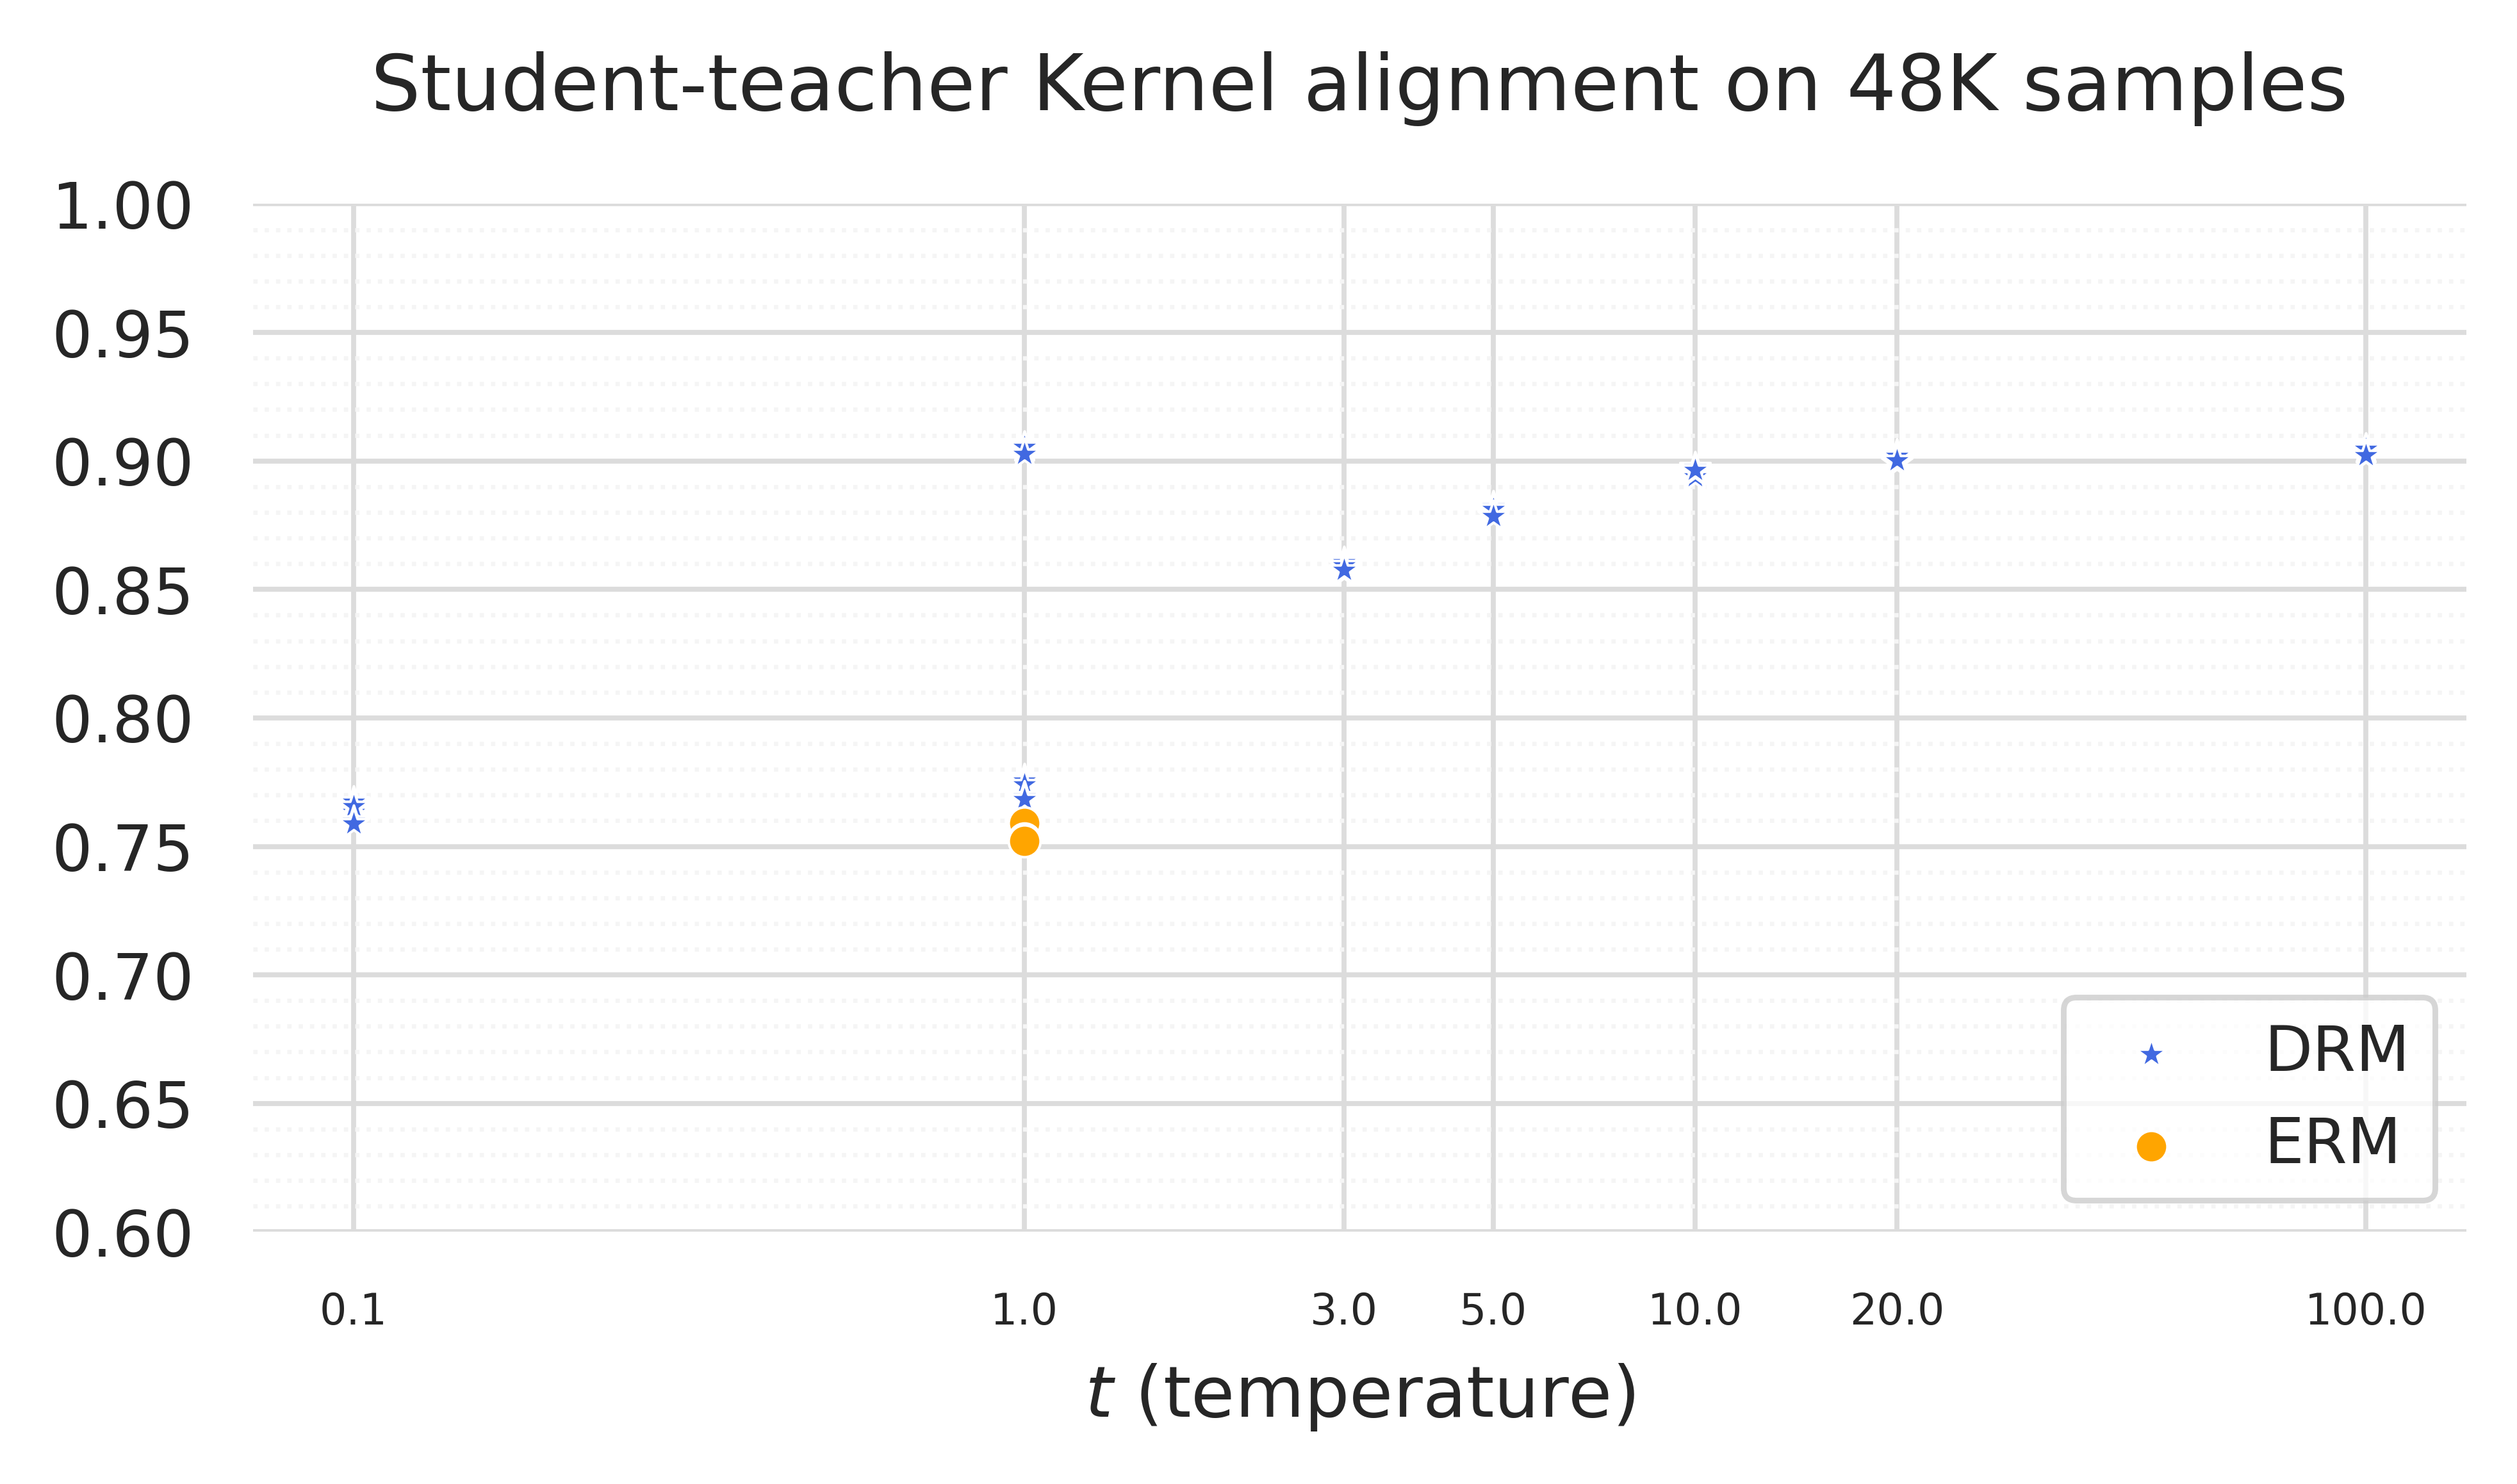

In [6]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray', 'purple', 'slateblue']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.scatterplot(data=_df, x="temperature", y="final_cka_train", marker='*', 
                    color=colors[0], s=40, ax=ax, label="distil.val")

    _df = working_df.loc[working_df['alpha']==1.0]

    sns.scatterplot(data=_df, x="temperature", y="final_cka_train", s=40,
                markers=True, marker='o', color=colors[1], ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    #ax.axhline(teacher_val_accuracy_rec, ls=':', color="tab:gray")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,20.])
    ax.set_ylim([0.6,1.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(temperatures)
    ax.set_xticklabels(temperatures, fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    #yticks = [0.0, 25.0, 50.0, 75., 100.0]
    #plt.yticks(yticks)
    #ax.set_yticklabels([0.0, 25.0, 50.0, f'{teacher_val_accuracy}', 100.0], fontsize=8)

    #ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Student-teacher Kernel alignment on 48K samples", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$t$ (temperature)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, [r'DRM',
                  r'ERM'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    # a = ax.get_ygridlines()
    # b = a[3]
    # b.set_color('tab:olive')
    # b.set_linewidth(0.8)
    # b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()

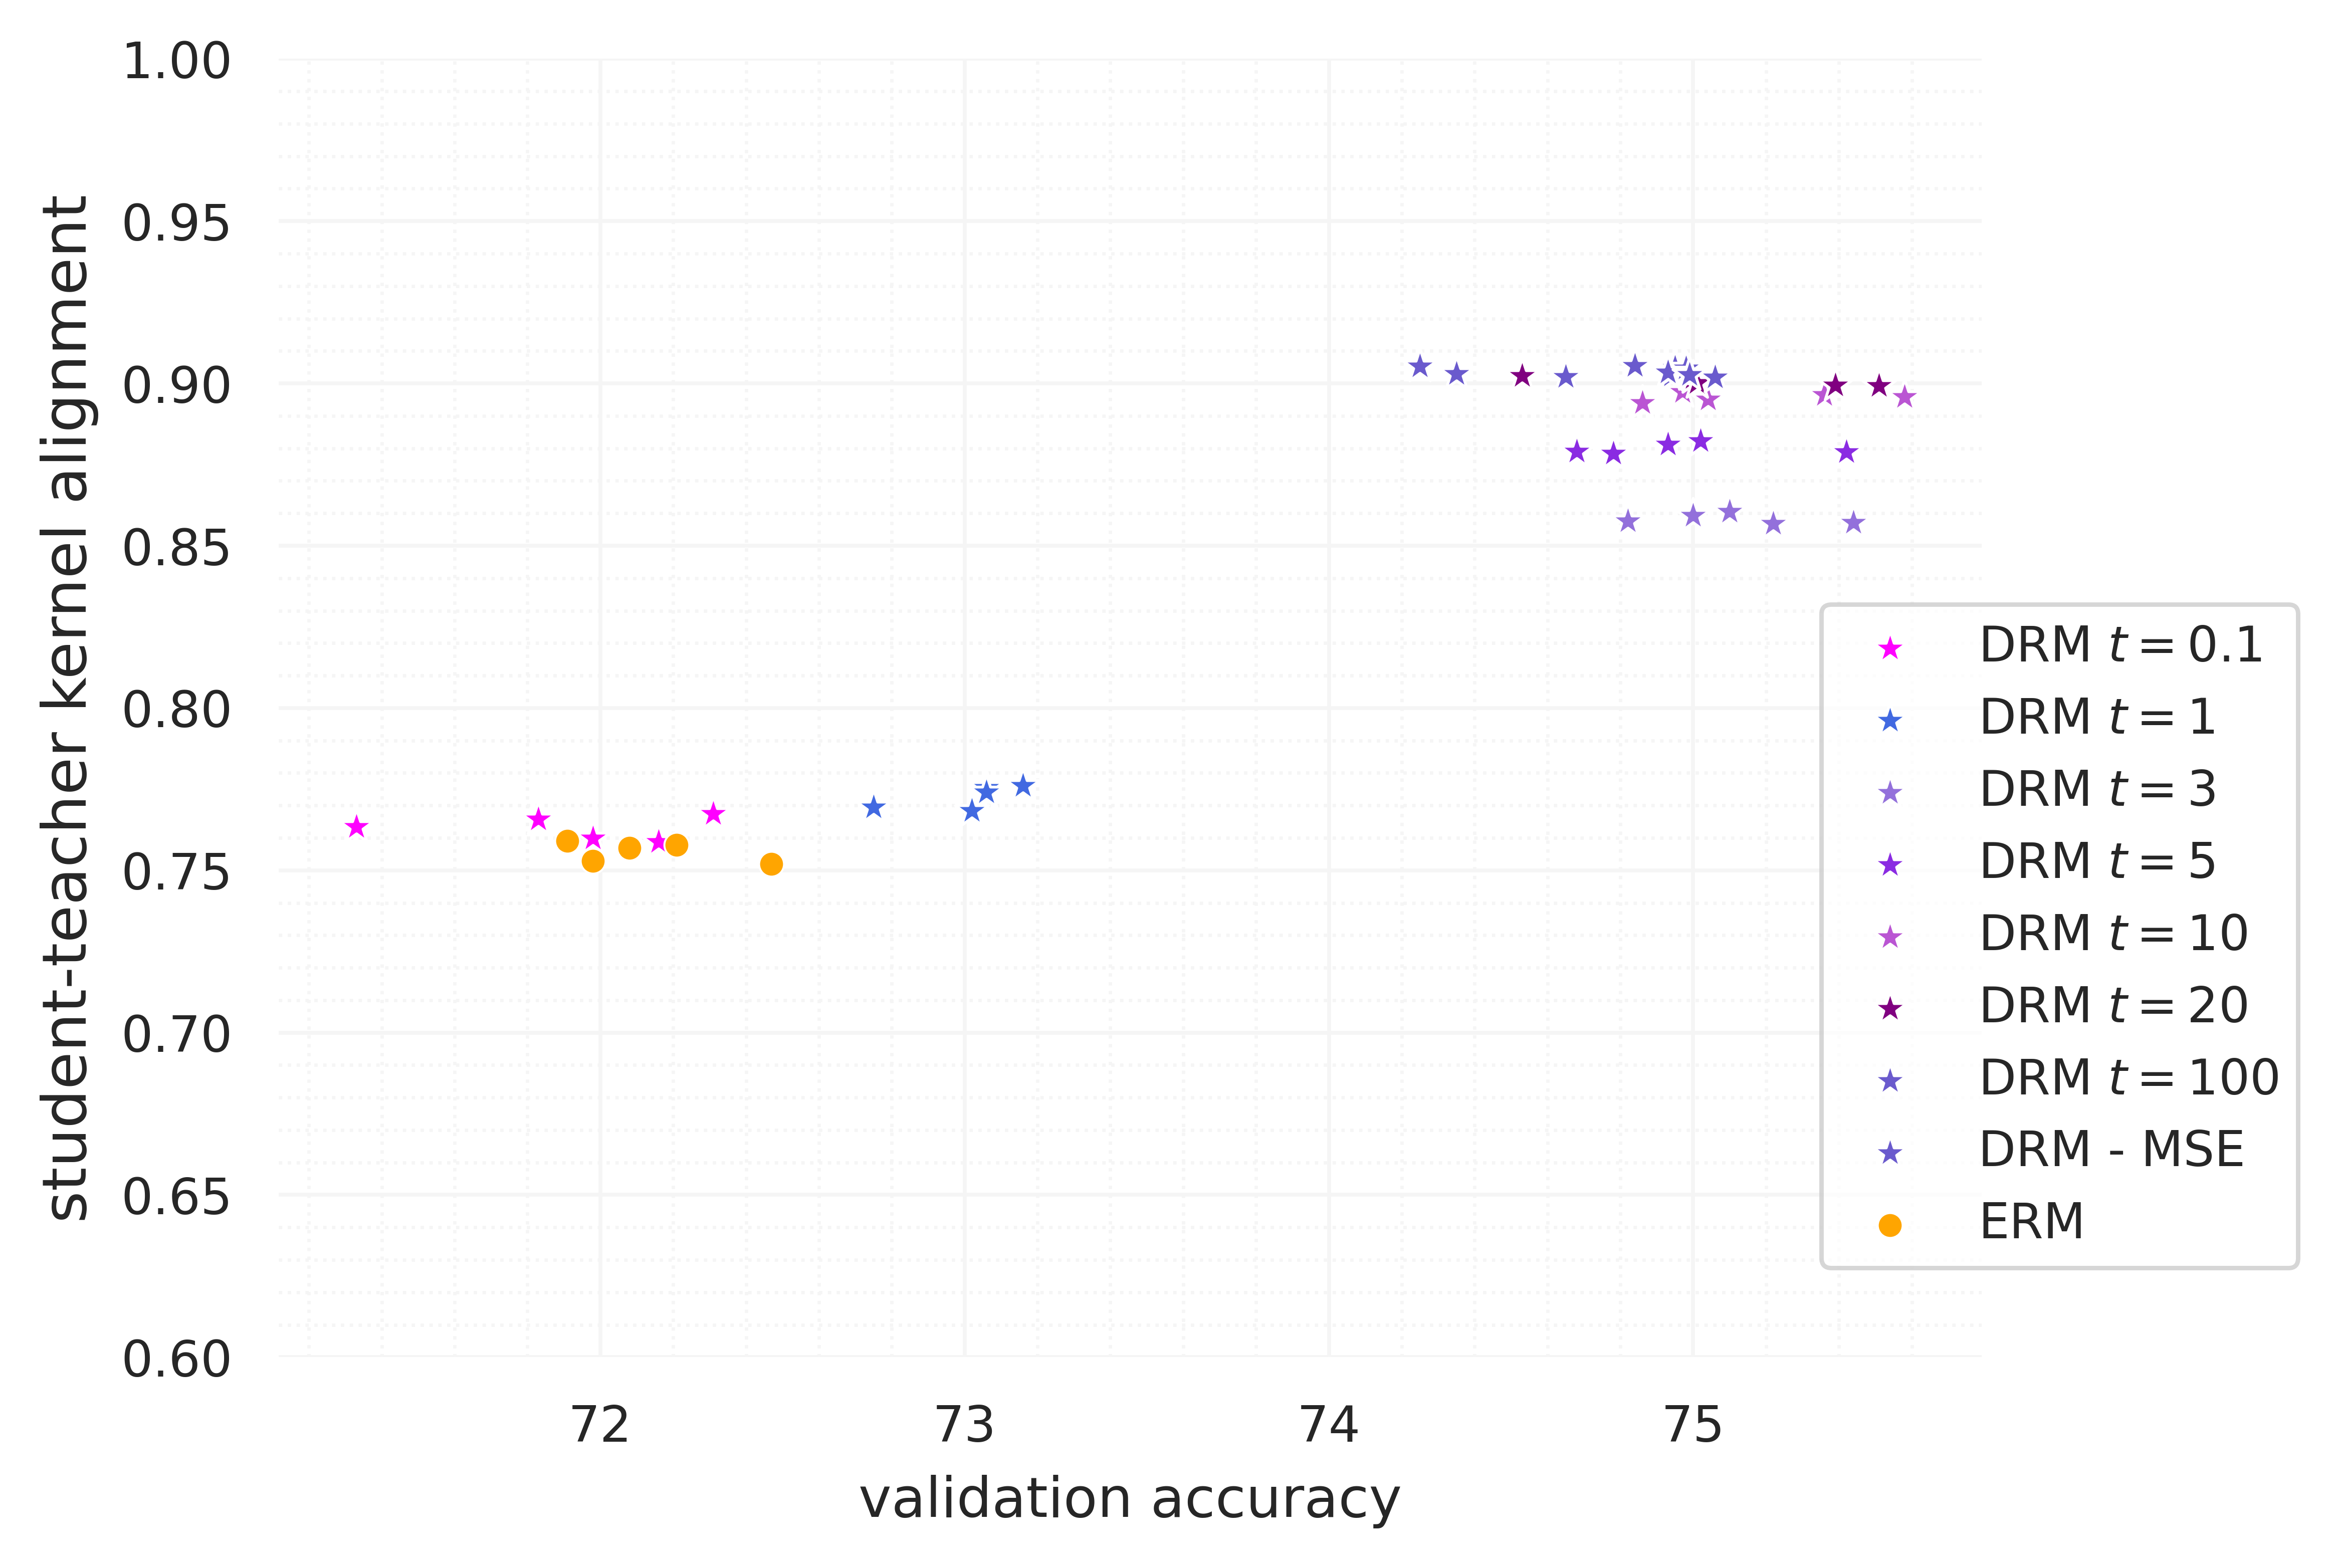

In [32]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(6,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray', 'purple', 'mediumorchid','blueviolet','mediumpurple', 'slateblue','darkmagenta','magenta','cyan']


    _df = working_df.loc[working_df['alpha']==0.0]
    _df2 = _df.loc[_df['temperature']==0.1][:26]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[9], s=40, ax=ax, label="distil.val")
    
    _df2 = _df.loc[_df['temperature']==1]
    _df2 = _df2.loc[_df2['MSE']==False]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[0], s=40, ax=ax, label="distil.val")
    
    _df2 = _df.loc[_df['temperature']==3]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[6], s=40, ax=ax, label="distil.val")
  
    
    _df2 = _df.loc[_df['temperature']==5]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[5], s=40, ax=ax, label="distil.val")
    

    _df2 = _df.loc[_df['temperature']==10]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[4], s=40, ax=ax, label="distil.val")
    
    _df2 = _df.loc[_df['temperature']==20]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[3], s=40, ax=ax, label="distil.val")
    

    _df2 = _df.loc[_df['temperature']==100]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[7], s=40, ax=ax, label="distil.val")
    
    _df2 = _df.loc[_df['MSE']==True]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[7], s=40, ax=ax, label="distil.val")
    

    _df = working_df.loc[working_df['alpha']==1.0]
    sns.scatterplot(data=_df, x="final_val_acc_S", y="final_cka_train", s=20, 
                markers=True, marker='o', color=colors[1], ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    #ax.axhline(teacher_val_accuracy_rec, ls=':', color="tab:gray")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,20.])
    ax.set_ylim([0.6,1.0])

    ax.tick_params(axis='both',  labelsize=9)
    #ax.set_xticks(temperatures)
    #ax.set_xticklabels(temperatures, fontsize=6)
    #ax.tick_params(axis='x',  rotation=0)

    #yticks = [0.0, 25.0, 50.0, 75., 100.0]
    #plt.yticks(yticks)
    #ax.set_yticklabels([0.0, 25.0, 50.0, f'{teacher_val_accuracy}', 100.0], fontsize=8)

    #ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    #ax.set_title(f"Student-teacher Kernel alignment VS Validation accuracyon 48K samples", fontsize=11, y=1.05)
    ax.set_ylabel(r'student-teacher kernel alignment', fontsize=11, x=-0.2)
    ax.set_xlabel(r'validation accuracy', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, [r'DRM $t=0.1$',
                  r'DRM $t=1$',
                  r'DRM $t=3$',
                  r'DRM $t=5$',
                  r'DRM $t=10$',
                  r'DRM $t=20$',
                  r'DRM $t=100$',
                  r'DRM - MSE',
                  r'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right",
                bbox_to_anchor=(1.2, 0.05))


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='whitesmoke', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    # a = ax.get_ygridlines()
    # b = a[3]
    # b.set_color('tab:olive')
    # b.set_linewidth(0.8)
    # b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()

In [60]:
working_df.loc[working_df['MSE']==True,'temperature'] = 'MSE'
working_df['T']= working_df['temperature'].astype('category')


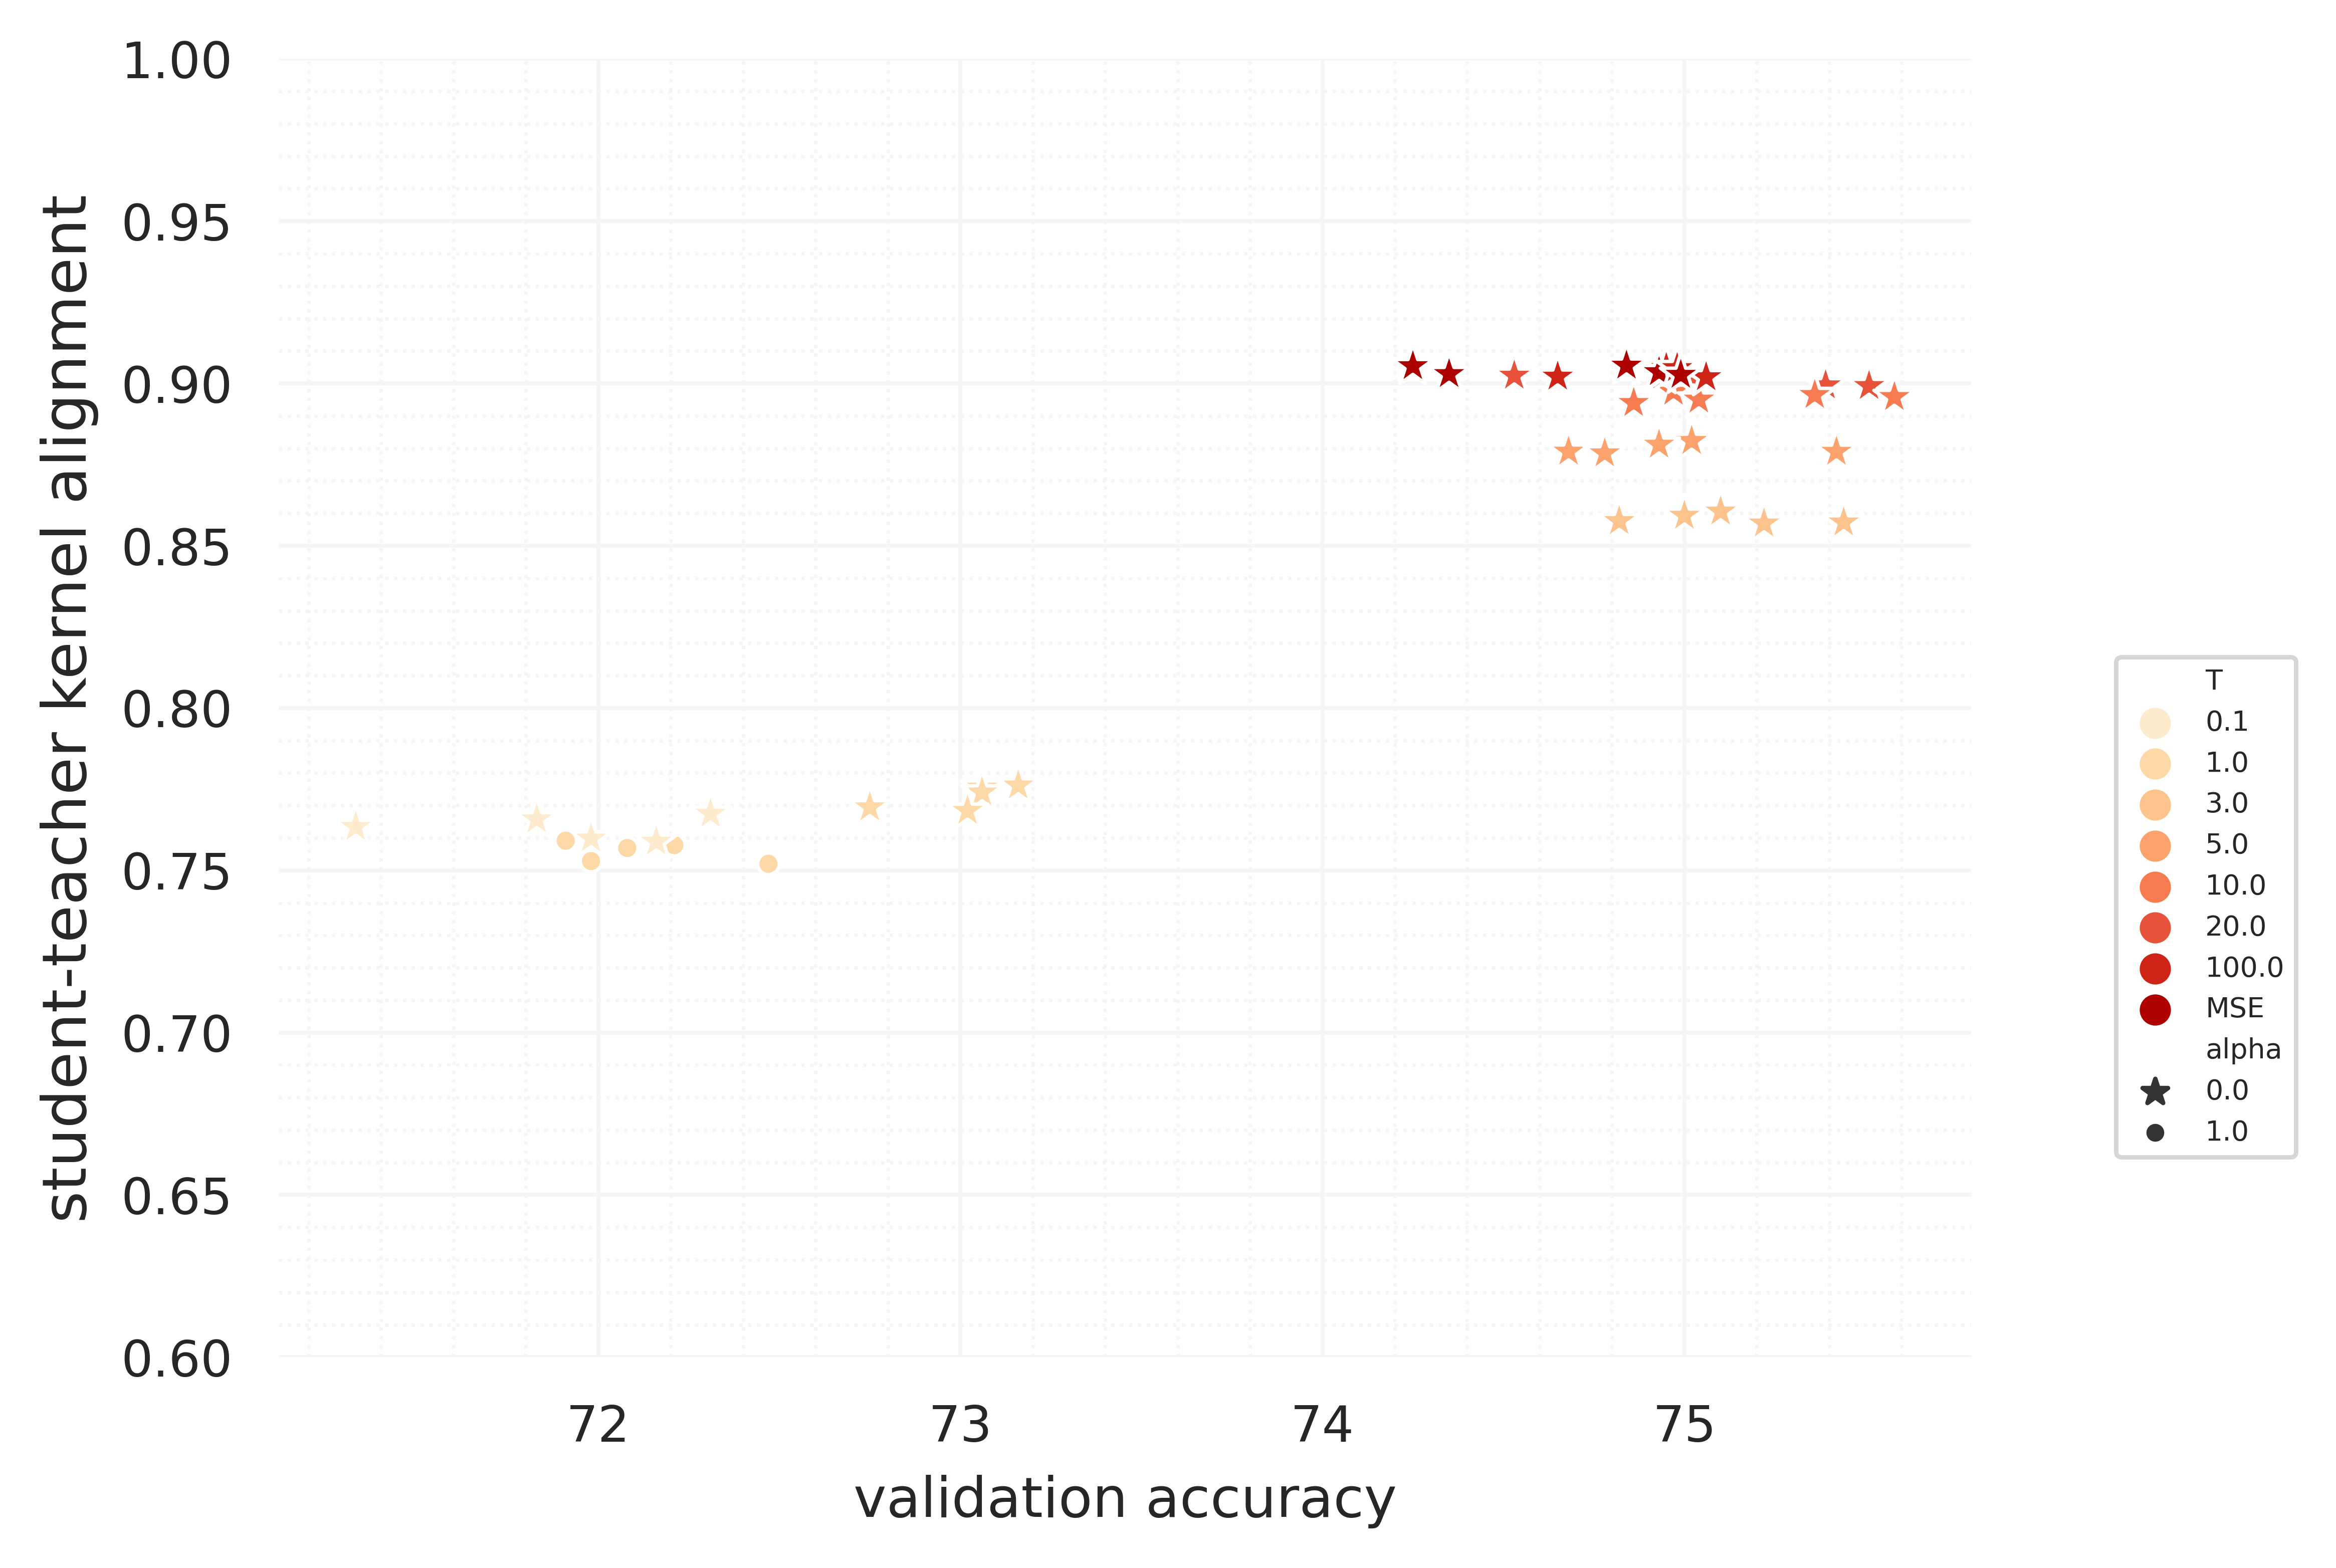

In [65]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(6,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray', 'purple', 'mediumorchid','blueviolet','mediumpurple', 'slateblue','darkmagenta','magenta','cyan']


    _df = working_df
    sns.scatterplot(data=_df, x="final_val_acc_S", y="final_cka_train", s=60, 
                markers=['*','.'], hue='T', style='alpha', ax=ax, palette="OrRd")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    #ax.axhline(teacher_val_accuracy_rec, ls=':', color="tab:gray")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,20.])
    ax.set_ylim([0.6,1.0])

    ax.tick_params(axis='both',  labelsize=9)
    #ax.set_xticks(temperatures)
    #ax.set_xticklabels(temperatures, fontsize=6)
    #ax.tick_params(axis='x',  rotation=0)

    #yticks = [0.0, 25.0, 50.0, 75., 100.0]
    #plt.yticks(yticks)
    #ax.set_yticklabels([0.0, 25.0, 50.0, f'{teacher_val_accuracy}', 100.0], fontsize=8)

    #ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    #ax.set_title(f"Student-teacher Kernel alignment VS Validation accuracyon 48K samples", fontsize=11, y=1.05)
    ax.set_ylabel(r'student-teacher kernel alignment', fontsize=11, x=-0.2)
    ax.set_xlabel(r'validation accuracy', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    # ax.legend(h, [r'DRM $t=0.1$',
    #               r'DRM $t=1$',
    #               r'DRM $t=3$',
    #               r'DRM $t=5$',
    #               r'DRM $t=10$',
    #               r'DRM $t=20$',
    #               r'DRM $t=100$',
    #               r'DRM - MSE',
    #               r'ERM'], 
    #             title="", ncol=1, loc="lower right",
    #             bbox_to_anchor=(1.2, 0.05))
    ax.legend(bbox_to_anchor=(1.2, 0.55), fontsize=5)


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='whitesmoke', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    # a = ax.get_ygridlines()
    # b = a[3]
    # b.set_color('tab:olive')
    # b.set_linewidth(0.8)
    # b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()